# NLP Model
## SMS Ham - or - Spam Classifier:

### Read in & clean text

In [1]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string


pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')


def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['message'])

X_features = pd.concat([data['length'], data['punct'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features.head()

,length,punct,0,1,2,3,4,5,6,7,...,8907,8908,8909,8910,8911,8912,8913,8914,8915,8916
0,111,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,155,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,49,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting data into test and train set

In [2]:
import warnings
from sklearn.model_selection import train_test_split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.20, random_state=42)

In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier as RF
rf = RF(n_estimators = 50, max_depth = 20, n_jobs = -1)
rf_model = rf.fit(X_train, y_train)

In [5]:
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.050076455735853544, 2157),
 (0.04153218494626043, 'length'),
 (0.037683390157871303, 1901),
 (0.03391501512096089, 5245),
 (0.027261825434148918, 6258),
 (0.025241991968867703, 3424),
 (0.02151150219986547, 7442),
 (0.020140406564230592, 7754),
 (0.02005102263185118, 8106),
 (0.01713158646215551, 5544)]

## Evaluation:

<AxesSubplot:>

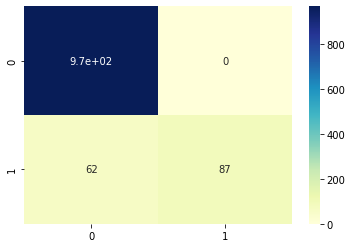

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = rf_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu')

In [7]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       966
        spam       1.00      0.58      0.74       149

    accuracy                           0.94      1115
   macro avg       0.97      0.79      0.85      1115
weighted avg       0.95      0.94      0.94      1115



## Hyperparameter tuning:

In [8]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
rf = RF()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_tfidf, data['label'])
scores = gs.best_params_
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,3.967085,0.008198,0.051214,0.001264,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.978475,0.974888,0.972172,0.964991,0.972172,0.972540,0.004427,1
6,0.266247,0.004175,0.005598,0.000099,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.975785,0.973991,0.977558,0.972172,0.962298,0.972361,0.005342,2
10,4.588992,0.297182,0.051293,0.003704,None,150,"{'max_depth': None, 'n_estimators': 150}",0.980269,0.972197,0.972172,0.965889,0.969479,0.972001,0.004736,3
8,6.707275,0.390194,0.080077,0.001106,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.980269,0.977578,0.970377,0.965889,0.964991,0.971821,0.006139,4
3,0.198701,0.001334,0.005187,0.000139,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.974888,0.973991,0.972172,0.965889,0.965889,0.970566,0.003918,5


In [10]:
print('Best parameters are:' , scores)

Best parameters are: {'max_depth': 90, 'n_estimators': 150}


## Evaluation:

<AxesSubplot:>

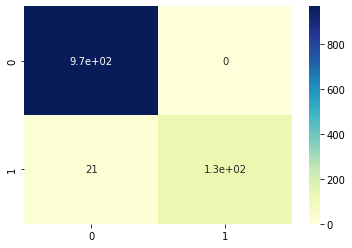

In [13]:
import seaborn as sns 
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier as RF
rf = RF(n_estimators = 150, max_depth = 90, n_jobs = -1)
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu')

In [14]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

